In [1]:
import cv2 
import numpy as np
from tifffile import TiffFile
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
import matplotlib.pyplot as plt



In [83]:

fh = r"F:\BactUnet\bactunet_val\OGM\EXP-20-BT0352\wt\hOGM_1_MMStack_Default.ome.tif\hOGM_1_MMStack_Default.ome.tif"

with TiffFile(fh) as tif:
    arr = tif.asarray()

arr = arr[1:-1,1,:,:]


fh = r"F:\BactUnet\thresholded_mcherry\global_otsu\masks_raw\hOGM_1_MMStack_Default.ome.tif"

with TiffFile(fh) as tif:
    arr_global = tif.asarray()

fh = r"F:\BactUnet\thresholded_mcherry\local_otsu\masks_raw\hOGM_1_MMStack_Default.ome.tif"

with TiffFile(fh) as tif:
    arr_local = tif.asarray()




In [89]:
i=150



print(arr.shape, arr.max(), arr.min(), arr[i].max(), arr[i].min(), arr[i].mean())
print(arr_global.shape, arr_global.max(), arr_global.min(), arr_global[i].max(), arr_global[i].min(), arr_global[i].mean())
print(arr_local.shape, arr_local.max(), arr_local.min(), arr_local[i].max(), arr_local[i].min(), arr_local[i].mean())






(238, 2304, 2304) 5677 36 210 47 104.65428331163194
(238, 2304, 2304) 5677 0 210 0 44.054674125012056
(238, 2304, 2304) 5677 0 210 0 44.054674125012056


In [100]:
def plot_comparison(images, names):
    n = len(images)
    fig, axis = plt.subplots(ncols=n, figsize=(n*10, 15), sharex=True,
                                   sharey=True)
    for image, name, ax in zip(images, names, axis):
        ax.imshow(image, cmap=plt.cm.gray)
        ax.set_title(name)
        ax.axis('off')
    

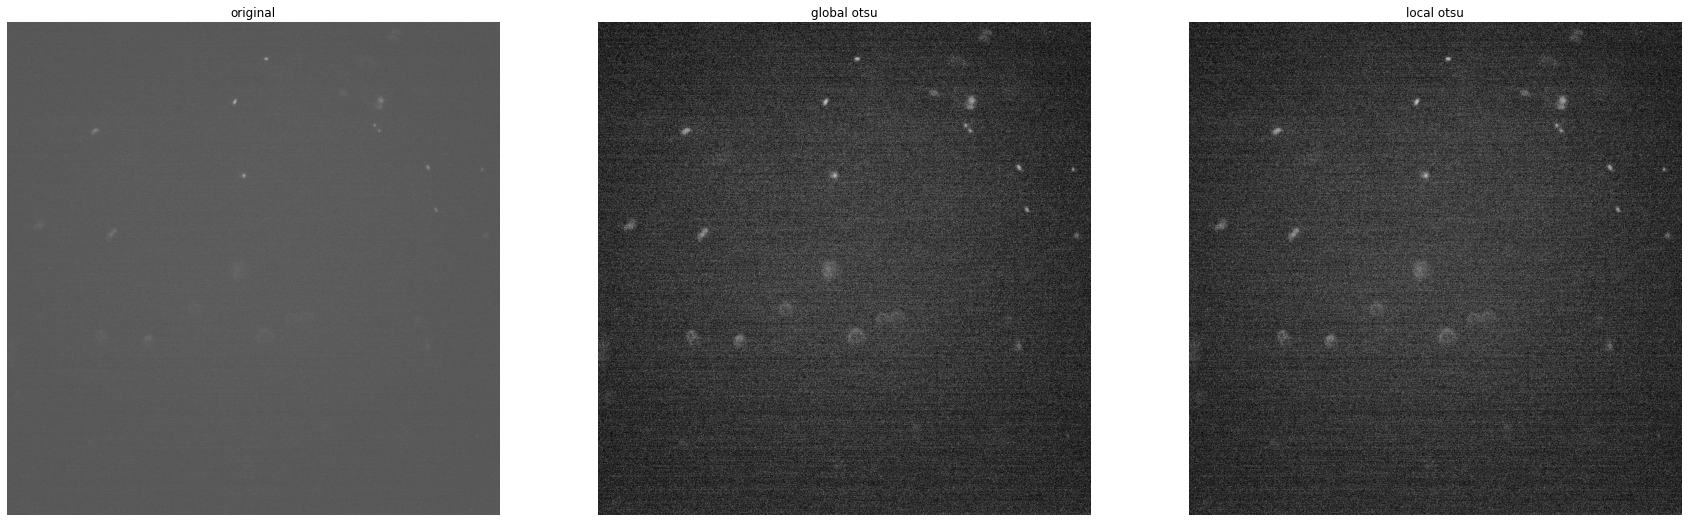

In [101]:
arrs = [arr[i], arr_global[i], arr_local[i]]
names = ['original', 'global otsu', 'local otsu']

plot_comparison(arrs, names)

In [115]:
from skimage.restoration import rolling_ball, ellipsoid_kernel
from  skimage.filters import gaussian

kernel = ellipsoid_kernel((25, 25), 75)

def apply_rolling_ball(frame):
    background = rolling_ball(frame, kernel=kernel)
    filtered_image = frame - background
    return filtered_image


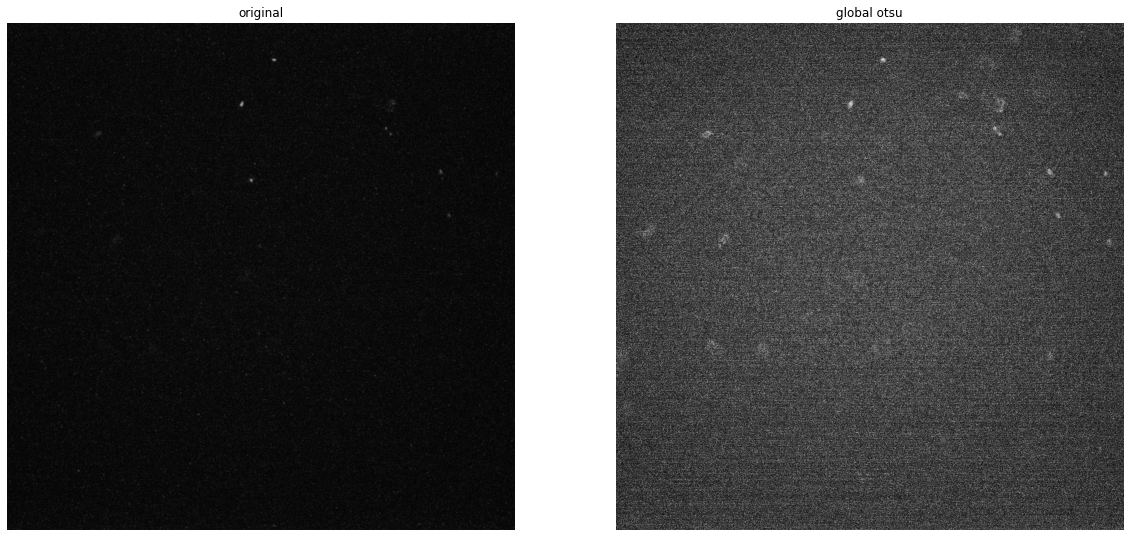

In [133]:
rb_arrs = []
for a in arrs[:-1]:
    a = gaussian(a, sigma=0.8, preserve_range=True)
    a = apply_rolling_ball(a)
    
    rb_arrs.append(a)
    
plot_comparison(rb_arrs, names)

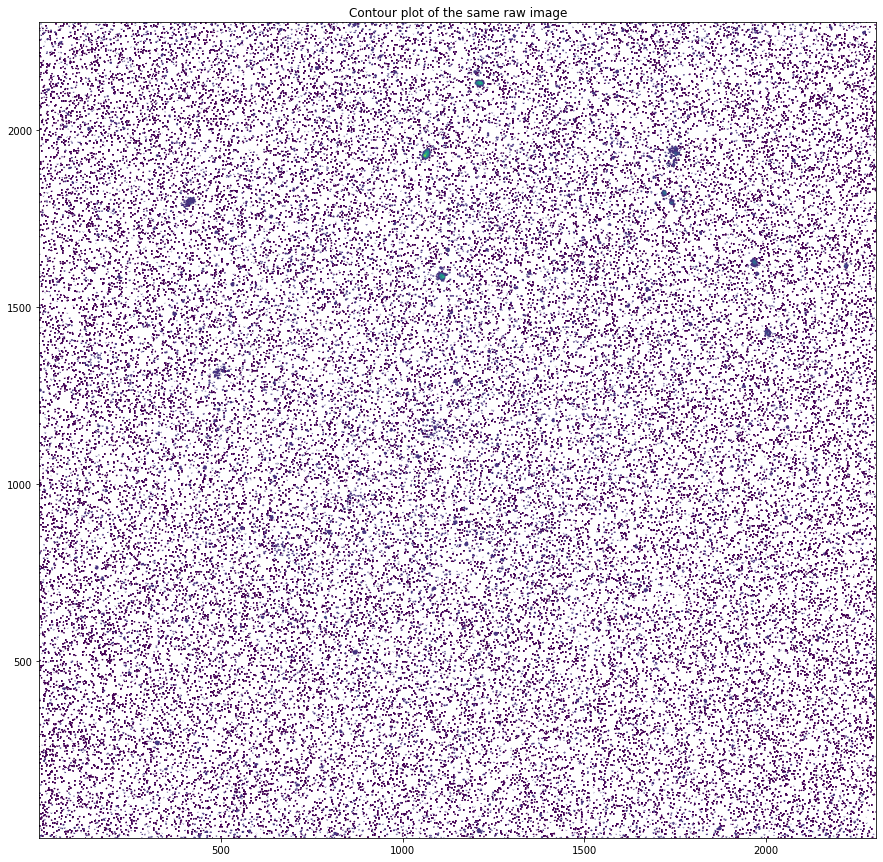

In [134]:
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)

from skimage import (color, feature, filters, measure, morphology, segmentation, util)

fig, ax = plt.subplots(figsize=(15, 15))
qcs = ax.contour(rb_arrs[0], origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()



In [136]:
import napari

viewer = napari.view_image(arr)

In [137]:
arr_blur = gaussian(arr, sigma=0.8, preserve_range=True)

viewer = napari.view_image(arr_blur)

In [140]:
arr_bb = np.zeros_like(arr_blur)

for i, frame in enumerate(arr_blur):
    
    arr_bb[i] = apply_rolling_ball(frame)

viewer = napari.view_image(arr_bb)

In [149]:
from skimage.filters import threshold_otsu

th = threshold_otsu(arr_bb)

print(arr.min(), arr.max(), arr_bb.min(), arr_bb.max(), th)

36 5677 0.0 1264.944677308222 2.470595072867621


In [153]:
test = arr_bb > th*2
test = erosion(test)
test = dilation(test)
viewer = napari.view_image(test)

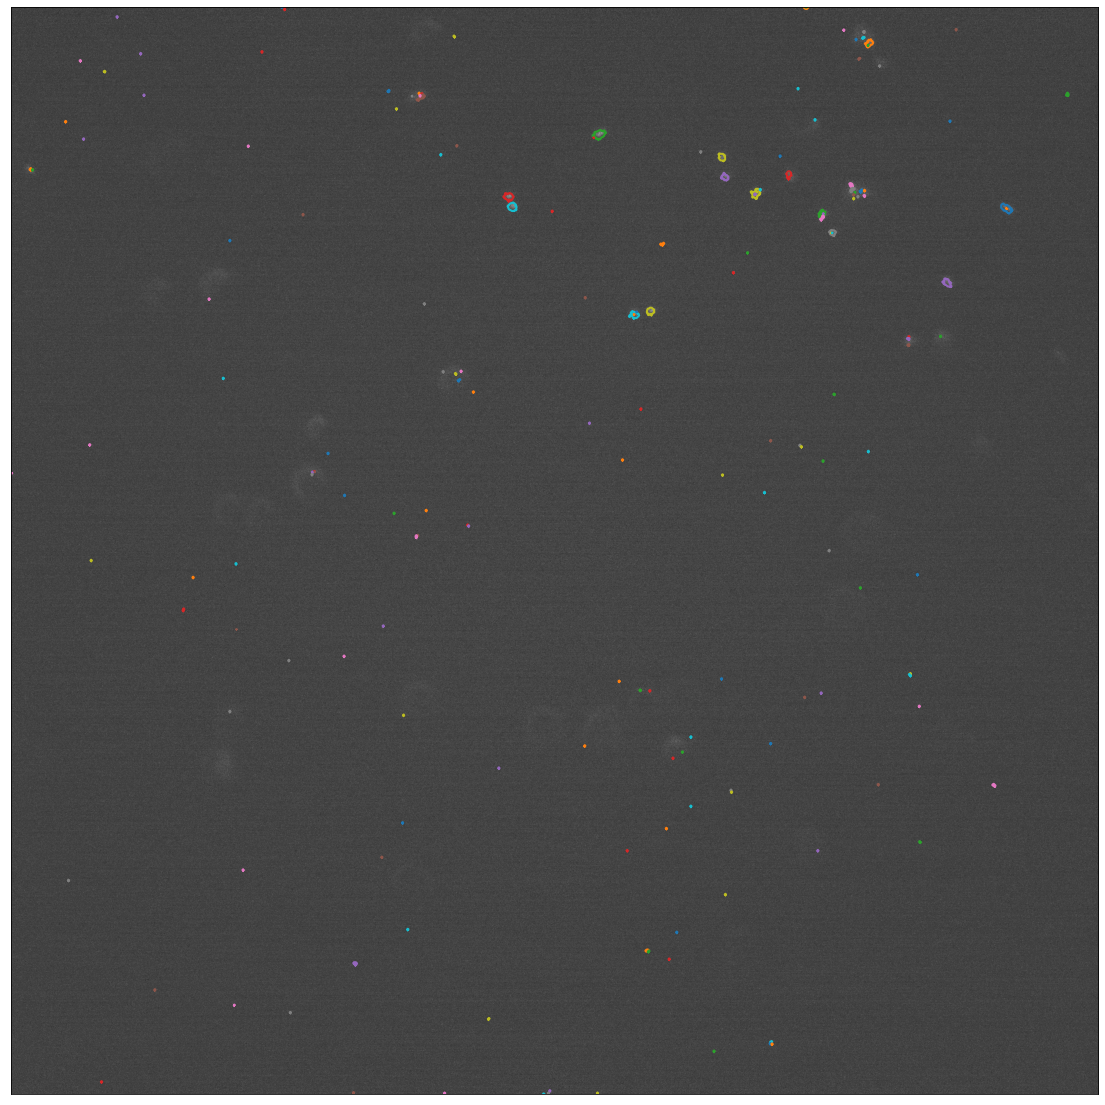

In [171]:
from skimage import measure

contours = measure.find_contours(test[i])

fig, ax = plt.subplots()
ax.imshow(arr[i], cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

15


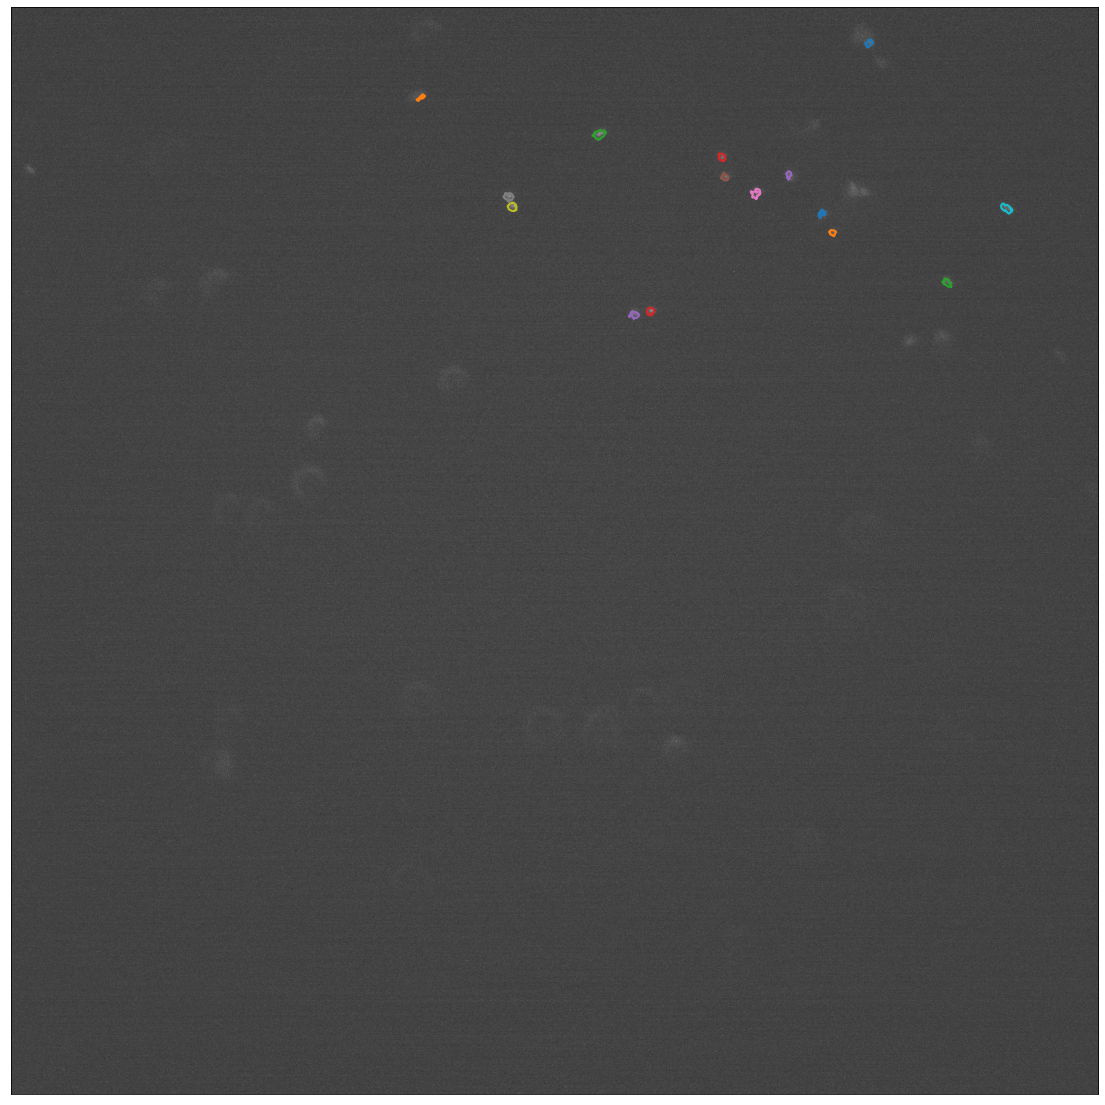

In [173]:
filtered_contours = []
for c in contours:
    if c.size > 100:
        filtered_contours.append(c)
        
fig, ax = plt.subplots()
ax.imshow(arr[i], cmap=plt.cm.gray)

for contour in filtered_contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
print(len(filtered_contours))
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [179]:
frame_bact = []
filt_cntr=[]
for frame in test:
    nbact = 0
    cntr = []
    contours = measure.find_contours(frame)
    for c in contours:
        if c.size > 100:
            nbact += 1
            cntr.append(c)
    frame_bact.append(nbact)
    filt_cntr.extend(cntr)
print(frame_bact)    

[1, 1, 1, 2, 3, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 3, 3, 6, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 5, 5, 6, 6, 6, 6, 5, 5, 5, 4, 3, 4, 5, 6, 5, 5, 4, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 6, 7, 7, 7, 7, 6, 5, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 8, 7, 8, 8, 7, 7, 9, 7, 9, 9, 10, 11, 9, 10, 10, 11, 10, 12, 12, 11, 10, 10, 9, 11, 12, 12, 12, 11, 13, 13, 11, 12, 12, 13, 12, 10, 10, 12, 10, 13, 12, 11, 13, 14, 15, 14, 15, 12, 15, 15, 12, 11, 12, 11, 12, 11, 16, 16, 17, 14, 15, 14, 13, 14, 14, 15, 15]


15


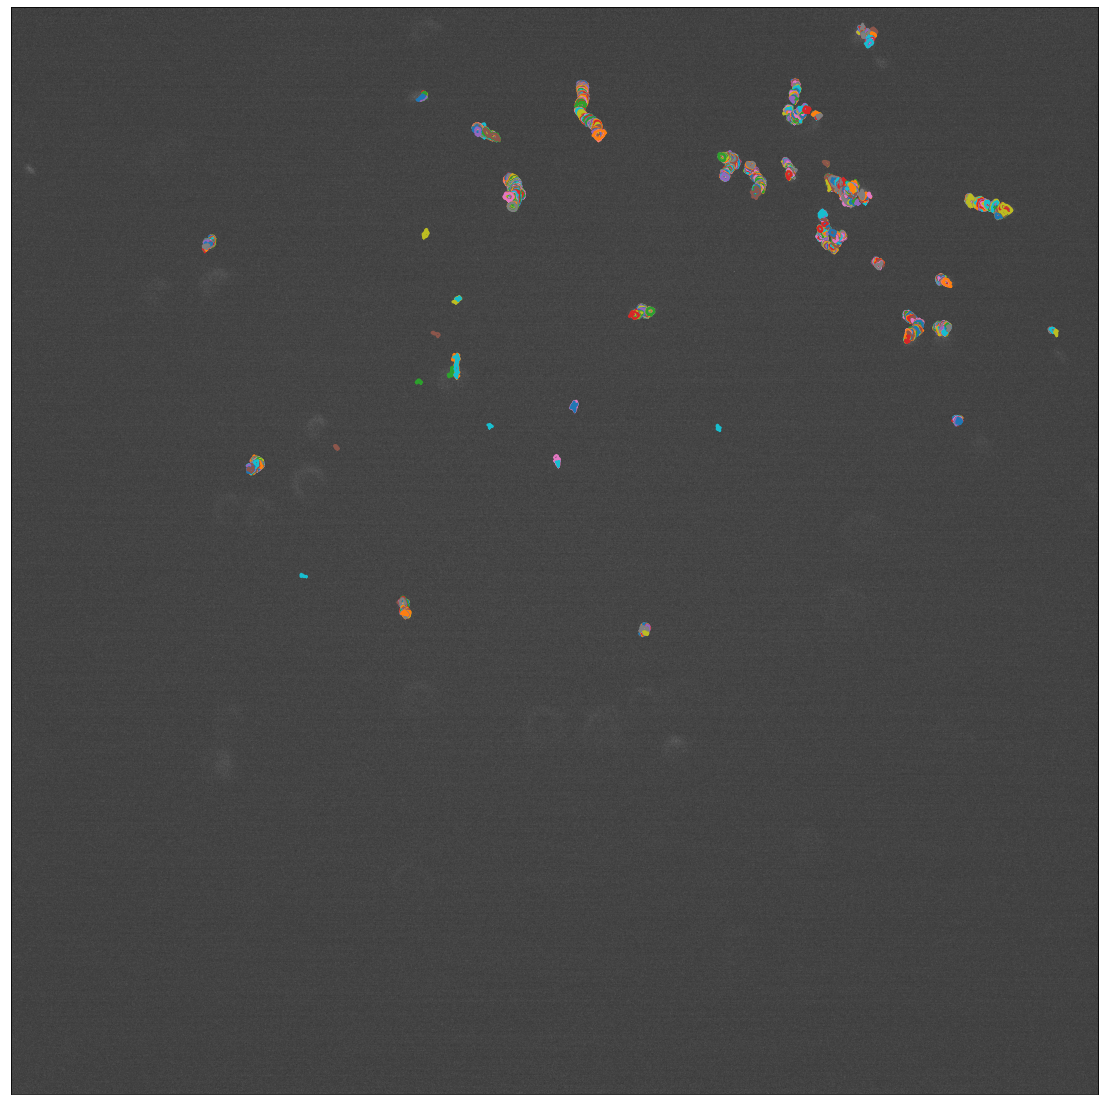

In [180]:
fig, ax = plt.subplots()
ax.imshow(arr[i], cmap=plt.cm.gray)

for contour in filt_cntr:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
print(len(filtered_contours))
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
#viewer = napari.view_image(test)

In [21]:
#9.5 min per file 
import numpy as np
from tifffile import TiffFile
from skimage.restoration import rolling_ball, ellipsoid_kernel
from skimage.filters import gaussian
from quantification_comparrison import getTemporalMedianFilter


fh = r"F:\BactUnet\bactunet_val\OGM\EXP-20-BT0352\wt\hOGM_1_MMStack_Default.ome.tif\hOGM_1_MMStack_Default.ome.tif"

with TiffFile(fh) as tif:
    arr = tif.asarray()

med_arr = getTemporalMedianFilter(arr[:,1,:,:],doGlidingProjection=True, startFrame=0, stopFrame=arr.shape[0])
arr = arr[1:-1,1,:,:]

kernel = ellipsoid_kernel((25, 25), 75)

def apply_rolling_ball(frame):
    background = rolling_ball(frame, kernel=kernel)
    filtered_image = frame - background
    return filtered_image

def bg_subtract(arr):   
    bg_arr = []
    for i in len(arr):
        a = gaussian(arr[i], sigma=0.8, preserve_range=True)
        a = apply_rolling_ball(a)
        bg_arr.append(a)
    return bg_arr

bg_arr = bg_subtract(arr)
bg_med = bg_subtract(med_arr)


KeyboardInterrupt: 

In [22]:
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation
from skimage.measure import find_contours

def count_bacteria(arr):
    bact_per_frame = []
    filt_cntr = []
    for frame in arr:

        th = threshold_otsu(frame)
        frame = frame > th*2
        frame = erosion(frame)
        frame = dilation(frame)
        frame_bact = []
        nbact = 0
        cntr = []
        contours = find_contours(frame)
        for c in contours:
            if c.size > 100:
                nbact += 1
                cntr.append(c)
        bact_per_frame.append(nbact)
        filt_cntr.extend(cntr)
    return bact_per_frame, filt_cntr

raw_bact = count_bacteria(rb_arr)
med_bact = count_bacteria(med_rb)

Text(0, 0.5, 'n. bacteria')

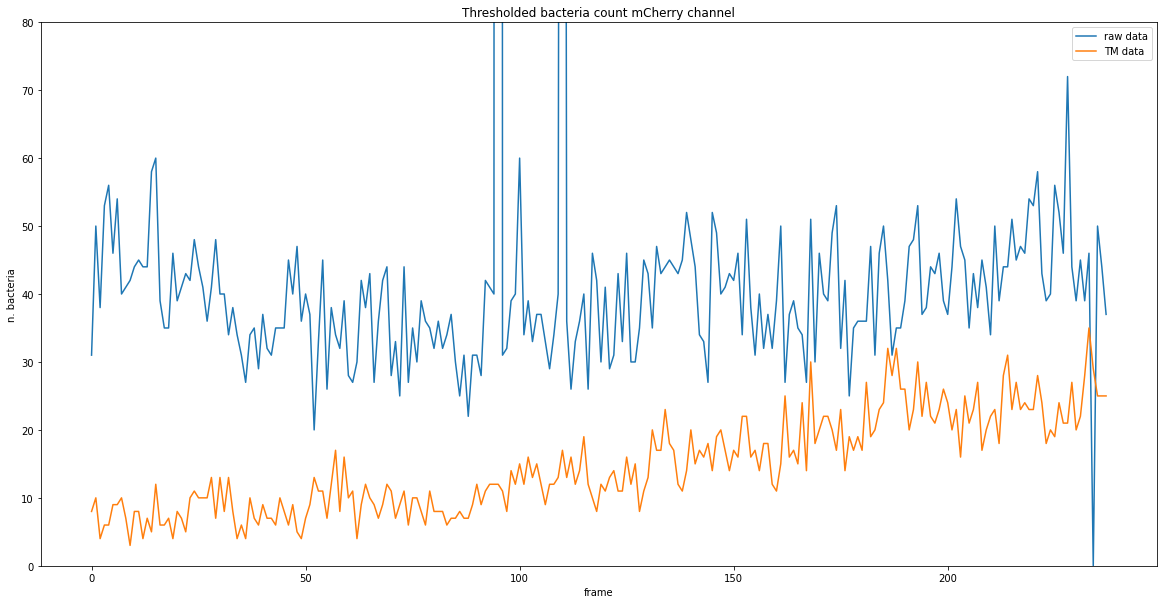

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(raw_bact[0], label='raw data')
ax.plot(med_bact[0], label='TM data')
ax.set_ylim(0,80)
ax.legend()
ax.set_title('Thresholded bacteria count mCherry channel')
ax.set_xlabel('frame')
ax.set_ylabel('n. bacteria')